## Regulation

### Data Augmentation
- Noise Injection

### Loss 
- Weight Decay

### Neural Network Layer
- Dropout
- Batch Normalization

### Training
- Early Stopping
- Bagging & Ensemble

## Weight Decay

### L2 Norm
- weight parameter가 원점에서 멀어지는 것을 방지
- Loss의 계산 과정에서 Loss down -> Weight up
- Loss가 다운될 때 Weight의 상승을 막아서 Normalization / 단, Bias는 제외  

#### Weight parameter는 노드와 노드 간의 관계를 나타냄
- W가 커질수록 Node간의 관계 강도가 강함  

### L1 Norm
- 노드 사이의 관계가 Sparse하도록 제한
- 더 적은 수의 입력 노드로부터 학습하도록 제한

#### => Loss minization을 방해함, Loss와 Weight의 상충성을 이용하여 균형지점을 찾음
- Loss와 Weight의 균형을 alpha Hyperparameter를 이용하여 조절
- optim.Adam or SGD에서 hyperparameter 조정 가능

## Data Augmentation
- Data의 핵심 Feature는 남겨두고, noise를 더하여 데이터를 확장 => Data set 늘리기
  - Heuristics한 방법을 이용
- 규칙이 있을경우 규칙마저 학습 / Randomness가 필요

### Text Augmentation
- Dropping: 임의로 단어 생략
- Exchange: 임의로 대상 단어를 주변 단어와 위치 교환  

### By Generative Models (GAN, Autoencoder)

## Dropout
- 학습시 임의로 Node를 동작하지 않도록 함
- 추론시 모든 노드를 동작시킴
  - 이때문에 학습시 p만큼의 비활성과 비교하여 추론시엔 1/p만큼의 더 큰 입력을 받음
  - 따라서 추론시 W에 p를 곱하여 이를 상쇄
  
#### Layer -> Activation -> Dropout -> Layer

## BatchNormalization
- Internal Covariance Shift Problem
  - backpropagation 이후 layer의 forward 결과가 달라짐
  - theat1 -> theta2 forward 과정에서 theta2의 경우 변경 전 theta1을 기준으로 update but... 바뀌었네?
- Standardization 후 shifting + scaling
- y = scale * standardization + shift / y = r * () + b
- r, b가 학습 parameter  
  
  
- 학습과 추론의 방법이 다름
  - mini-batch에서 u, theta를 계산하기 때문에 batch_size > 1
  - 추론시 mini-batch 내에서 계산하는 것은 다은 입력을 보는 것과 같음
    - 입력이 들어올 때 마다 moving average, std 계산이 필요  
    
Layer -> Activation -> BN -> Layer  
Layer -> BN -> Activation -> Layer  
둘의 성능차이는 없기때문에, dropout 위치에 넣어도 상관없음

#### No hyperparameter / 그런데 왜 동작하는지는 정확히 모름 / RNN에서는 사용 불가(Layer Normalization 사용 가능)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from torchvision import datasets, transforms

In [11]:
train = datasets.MNIST(
    './data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)
test = datasets.MNIST(
    './data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

In [15]:
x = train.data.float() / 255.
y = train.targets

x = x.view(x.size(0), -1)
print(x.shape, y.shape)

input_size = x.size(-1)
output_size = int(max(y)) + 1

print('input_size: %d, output_size: %d' % (input_size, output_size))

torch.Size([60000, 784]) torch.Size([60000])
input_size: 784, output_size: 10


In [16]:
ratios = [.8, .2]
train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnt = [train_cnt, valid_cnt]

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnt, dim=0))
y = list(y.split(cnt, dim=0))

x += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [18]:
class Block(nn.Module):
    
    def __init__(self,
                 input_size,
                 output_size,
                 use_batch_norm=True,
                 dropout_p=.4):
        self.input_size = input_size
        self.output_size = output_size
        self.use_batch_norm = use_batch_norm
        self.dropout_p = dropout_p
        
        super().__init__()
        
        def get_regularizer(use_batch_norm, size):
            return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p)
        
        self.block = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.LeakyReLU(),
            get_regularizer(use_batch_norm, output_size)
        )
        
    def forward(self, x):
        y = self.block(x)
        
        return y

In [22]:
class MyModel(nn.Module):
    
    def __init__(self,
                 input_size,
                 output_size,
                 use_batch_norm=True,
                 dropout_p=.4):
        
        super().__init__()
        
        self.layers = nn.Sequential(
            Block(input_size, 500, use_batch_norm, dropout_p),
            Block(500, 400, use_batch_norm, dropout_p),
            Block(400, 300, use_batch_norm, dropout_p),
            Block(300, 200, use_batch_norm, dropout_p),
            Block(200, 100, use_batch_norm, dropout_p),
            nn.Linear(100, output_size),
            nn.LogSoftmax(dim=-1),
        )
        
    def forward(self, x):
        y = self.layers(x)
        
        return y

In [31]:
model = MyModel(input_size,
                output_size,
                use_batch_norm=True)

model

MyModel(
  (layers): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=500, out_features=400, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=400, out_features=300, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Block(
      (block): Sequential(
        (0): Linear(in_features=300, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(200, e

In [32]:
crit = nn.NLLLoss()

In [33]:
optimizer = optim.Adam(model.parameters())

In [34]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

In [35]:
model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

In [36]:
n_epochs = 1000
batch_size = 256
print_interval = 10

In [37]:
from copy import deepcopy

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

In [38]:
train_history, valid_history = [], []

for i in range(n_epochs):
    model.train()
    
    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    
    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)
    
    train_loss = 0
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        train_loss += float(loss)
    
    train_loss = train_loss / len(x_)
    
    model.eval()
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)
        
        valid_loss = 0
        
        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())
            
            valid_loss += float(loss)
            
    valid_loss = valid_loss / len(x_)
    
    train_history += [train_loss]
    valid_history += [valid_loss]
    
    if (i + 1) % print_interval == 0:
        print('Epoch %d: train_loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
             (i + 1),
             train_loss,
             valid_loss,
             lowest_loss
        ))
    
    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        
        best_model = deepcopy(model.state_dict())
        
    else :
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print('No Improvement during last %d epochs.' % early_stop)
            break
            
print('Best validation loss from epoch %d: %.4e' % (lowest_epoch, lowest_loss))
model.load_state_dict(best_model)

Epoch 10: train_loss=1.9552e-02  valid_loss=8.1424e-02  lowest_loss=8.0092e-02
Epoch 20: train_loss=1.0327e-02  valid_loss=8.6426e-02  lowest_loss=7.0746e-02
Epoch 30: train_loss=7.8174e-03  valid_loss=8.5152e-02  lowest_loss=6.5998e-02
Epoch 40: train_loss=7.1897e-03  valid_loss=9.2464e-02  lowest_loss=6.5998e-02
Epoch 50: train_loss=6.9998e-03  valid_loss=8.1685e-02  lowest_loss=6.5998e-02
Epoch 60: train_loss=2.7548e-03  valid_loss=7.6672e-02  lowest_loss=6.5998e-02
Epoch 70: train_loss=9.7034e-04  valid_loss=8.3917e-02  lowest_loss=6.5998e-02
No Improvement during last 50 epochs.
Best validation loss from epoch 22: 6.5998e-02


<All keys matched successfully>

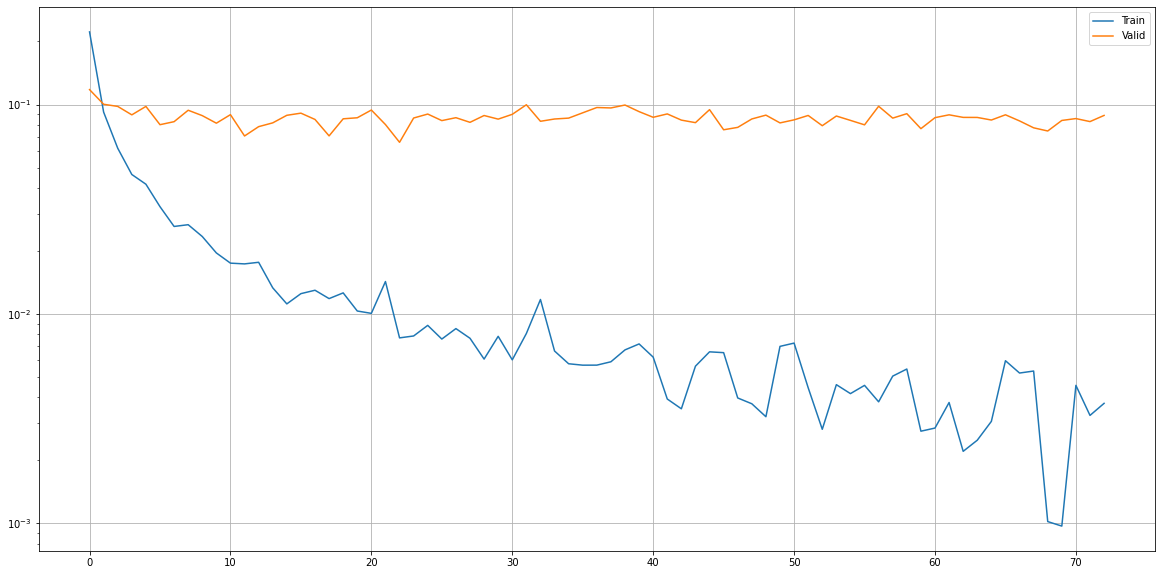

In [40]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.plot(range(plot_from, len(train_history)), train_history[plot_from:], label='Train')
plt.plot(range(plot_from, len(valid_history)), valid_history[plot_from:], label='Valid')
plt.yscale('log')
plt.legend()
plt.show()

In [41]:
test_loss = 0

y_hat = []

model.eval()
with torch.no_grad():
    x_ = x[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)
    
    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())
        
        test_loss += float(loss)
        y_hat += [y_hat_i]
        
test_loss = test_loss / len(x_)

print('Test loss: %.4e' % test_loss)

Test loss: 6.2506e-02


In [44]:
y_hat = torch.cat(y_hat, dim=0)

correct_cnt = (y[-1].squeeze() == torch.argmax(y_hat, dim=-1)).sum()
total_cnt = float(y[-1].size(0))

print('Accuracy: %.4f' % (correct_cnt / total_cnt))

Accuracy: 0.9840


In [45]:
import pandas as pd
from sklearn.metrics import confusion_matrix

In [47]:
pd.DataFrame(confusion_matrix(y[-1], torch.argmax(y_hat, dim=-1)),
             index=['true_%d' % i for i in range(output_size)],
             columns=['pred_%d' % i for i in range(output_size)])

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9
true_0,971,0,0,0,0,1,4,0,2,2
true_1,0,1128,1,0,0,1,1,1,3,0
true_2,1,2,1012,4,1,0,0,4,8,0
true_3,0,0,0,995,0,5,0,4,2,4
true_4,0,0,4,0,961,0,4,1,1,11
true_5,2,0,0,5,2,874,4,1,3,1
true_6,4,2,0,1,2,2,945,0,2,0
true_7,1,1,5,0,1,0,0,1009,3,8
true_8,1,1,2,4,1,3,1,2,956,3
true_9,3,2,0,0,9,2,0,1,3,989
